# NFL Predictive Model


In [2]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             classification_report, confusion_matrix)
from sklearn.neighbors import KNeighborsClassifier

In [3]:
seasons = seasons = [str(season) for season in range(2015, 2025)]
# load data
nfl_df = pd.read_csv(f'../data/nfl_data_{seasons[0]}-{seasons[-1]}.csv')

# explore data
with pd.option_context("display.max_colwidth", None, "display.max_columns", None):
    display(nfl_df)

,Season,Week,Team,Date,Win,Home,Opp,Team_Pts,Opp_Pts,Spread,Total
0,2015,1,Cardinals,13-Sep,1,1,Saints,31,19,-2.0,48.5
1,2015,2,Cardinals,20-Sep,1,0,Bears,48,23,-2.0,46.0
2,2015,3,Cardinals,27-Sep,1,1,49ers,47,7,-6.5,45.0
3,2015,5,Cardinals,11-Oct,1,0,Lions,42,17,-3.0,45.5
4,2015,6,Cardinals,18-Oct,0,0,Steelers,13,25,-3.5,45.0
...,...,...,...,...,...,...,...,...,...,...,...
5193,2024,13,Commanders,01-Dec,1,1,Titans,42,19,-6.0,44.5
5194,2024,15,Commanders,15-Dec,1,0,Saints,20,19,-7.5,43.5
5195,2024,16,Commanders,22-Dec,1,1,Eagles,36,33,4.0,46.5
5196,2024,17,Commanders,29-Dec,1,1,Falcons,30,24,-3.5,46.5


In [4]:
# Add Columns
# True Total
nfl_df['True_Total'] = nfl_df['Team_Pts'] + nfl_df['Opp_Pts']

# Total Result
nfl_df['Over'] = np.where(nfl_df['True_Total'] > nfl_df['Total'], 1, 0)
nfl_df['Under'] = np.where(nfl_df['True_Total'] < nfl_df['Total'], 1, 0)
nfl_df['Push'] = np.where(nfl_df['True_Total'] == nfl_df['Total'], 1, 0)

with pd.option_context("display.max_colwidth", None, "display.max_columns", None):
    display(nfl_df)

,Season,Week,Team,Date,Win,Home,Opp,Team_Pts,Opp_Pts,Spread,Total,True_Total,Over,Under,Push
0,2015,1,Cardinals,13-Sep,1,1,Saints,31,19,-2.0,48.5,50,1,0,0
1,2015,2,Cardinals,20-Sep,1,0,Bears,48,23,-2.0,46.0,71,1,0,0
2,2015,3,Cardinals,27-Sep,1,1,49ers,47,7,-6.5,45.0,54,1,0,0
3,2015,5,Cardinals,11-Oct,1,0,Lions,42,17,-3.0,45.5,59,1,0,0
4,2015,6,Cardinals,18-Oct,0,0,Steelers,13,25,-3.5,45.0,38,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5193,2024,13,Commanders,01-Dec,1,1,Titans,42,19,-6.0,44.5,61,1,0,0
5194,2024,15,Commanders,15-Dec,1,0,Saints,20,19,-7.5,43.5,39,0,1,0
5195,2024,16,Commanders,22-Dec,1,1,Eagles,36,33,4.0,46.5,69,1,0,0
5196,2024,17,Commanders,29-Dec,1,1,Falcons,30,24,-3.5,46.5,54,1,0,0


In [5]:
# Sort by Season and Week
nfl_df.sort_values(by=["Season", "Week"], ascending=True, inplace=True)

# Keep only Home Games to remove duplicate rows
nfl_df = nfl_df[nfl_df["Home"] == 1]

# Reset index after filtering
nfl_df.reset_index(drop=True, inplace=True)

with pd.option_context("display.max_colwidth", None, "display.max_columns", None):
    display(nfl_df)

,Season,Week,Team,Date,Win,Home,Opp,Team_Pts,Opp_Pts,Spread,Total,True_Total,Over,Under,Push
0,2015,1,Cardinals,13-Sep,1,1,Saints,31,19,-2.0,48.5,50,1,0,0
1,2015,1,Falcons,14-Sep,1,1,Eagles,26,24,2.5,54.5,50,0,1,0
2,2015,1,Bills,13-Sep,1,1,Colts,27,14,2.5,45.0,41,0,1,0
3,2015,1,Bears,13-Sep,0,1,Packers,23,31,6.5,49.0,54,1,0,0
4,2015,1,Cowboys,13-Sep,1,1,Giants,27,26,-6.0,51.5,53,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2594,2024,18,Jets,05-Jan,1,1,Dolphins,32,20,0.0,39.0,52,1,0,0
2595,2024,18,Eagles,05-Jan,1,1,Giants,20,13,-2.5,37.0,33,0,1,0
2596,2024,18,Steelers,04-Jan,0,1,Bengals,17,19,2.5,47.5,36,0,1,0
2597,2024,18,Buccaneers,05-Jan,1,1,Saints,27,19,-14.0,45.0,46,1,0,0


## Model

Processing season: 2021
 Week  1: Accuracy: 43.75%
 Week  2: Accuracy: 31.25%
 Week  3: Accuracy: 62.50%
 Week  4: Accuracy: 43.75%
 Week  5: Accuracy: 56.25%
 Week  6: Accuracy: 53.85%
 Week  7: Accuracy: 38.46%
 Week  8: Accuracy: 40.00%
 Week  9: Accuracy: 71.43%
 Week 10: Accuracy: 61.54%
 Week 11: Accuracy: 53.33%
 Week 12: Accuracy: 40.00%
 Week 13: Accuracy: 35.71%
 Week 14: Accuracy: 53.85%
 Week 15: Accuracy: 37.50%
 Week 16: Accuracy: 62.50%
 Week 17: Accuracy: 60.00%
 Week 18: Accuracy: 60.00%
Season 2021: Total accuracy score=50.19%

Classification Report for 2021:
              precision    recall  f1-score   support

        Over       0.47      0.51      0.49       124
       Under       0.54      0.50      0.52       143

    accuracy                           0.50       267
   macro avg       0.50      0.50      0.50       267
weighted avg       0.50      0.50      0.50       267



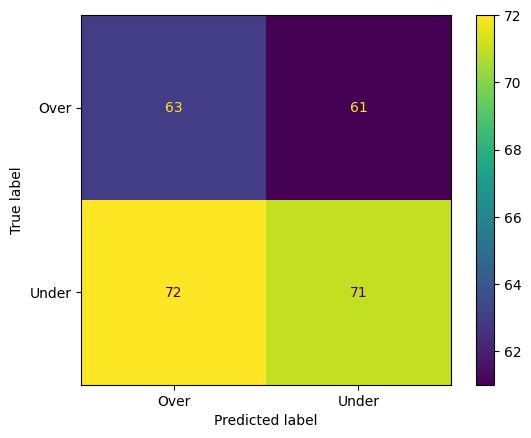

Processing season: 2022
 Week  1: Accuracy: 37.50%
 Week  2: Accuracy: 37.50%
 Week  3: Accuracy: 80.00%
 Week  4: Accuracy: 50.00%
 Week  5: Accuracy: 75.00%
 Week  6: Accuracy: 64.29%
 Week  7: Accuracy: 64.29%
 Week  8: Accuracy: 42.86%
 Week  9: Accuracy: 23.08%
 Week 10: Accuracy: 35.71%
 Week 11: Accuracy: 57.14%
 Week 12: Accuracy: 68.75%
 Week 13: Accuracy: 46.67%
 Week 14: Accuracy: 38.46%
 Week 15: Accuracy: 43.75%
 Week 16: Accuracy: 43.75%
 Week 17: Accuracy: 80.00%
 Week 18: Accuracy: 56.25%
Season 2022: Total accuracy score=52.79%

Classification Report for 2022:
              precision    recall  f1-score   support

        Over       0.47      0.56      0.51       119
       Under       0.59      0.50      0.54       150

    accuracy                           0.53       269
   macro avg       0.53      0.53      0.53       269
weighted avg       0.54      0.53      0.53       269



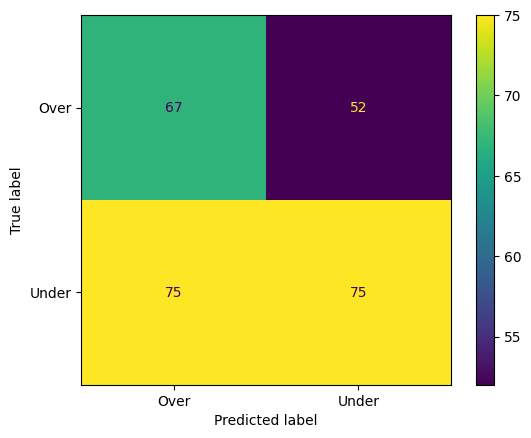

Processing season: 2023
 Week  1: Accuracy: 40.00%
 Week  2: Accuracy: 68.75%
 Week  3: Accuracy: 50.00%
 Week  4: Accuracy: 62.50%
 Week  5: Accuracy: 57.14%
 Week  6: Accuracy: 60.00%
 Week  7: Accuracy: 53.85%
 Week  8: Accuracy: 56.25%
 Week  9: Accuracy: 71.43%
 Week 10: Accuracy: 42.86%
 Week 11: Accuracy: 63.64%
 Week 12: Accuracy: 81.25%
 Week 13: Accuracy: 38.46%
 Week 14: Accuracy: 40.00%
 Week 15: Accuracy: 50.00%
 Week 16: Accuracy: 26.67%
 Week 17: Accuracy: 40.00%
 Week 18: Accuracy: 40.00%
Season 2023: Total accuracy score=52.45%

Classification Report for 2023:
              precision    recall  f1-score   support

        Over       0.48      0.48      0.48       121
       Under       0.56      0.56      0.56       144

    accuracy                           0.52       265
   macro avg       0.52      0.52      0.52       265
weighted avg       0.52      0.52      0.52       265



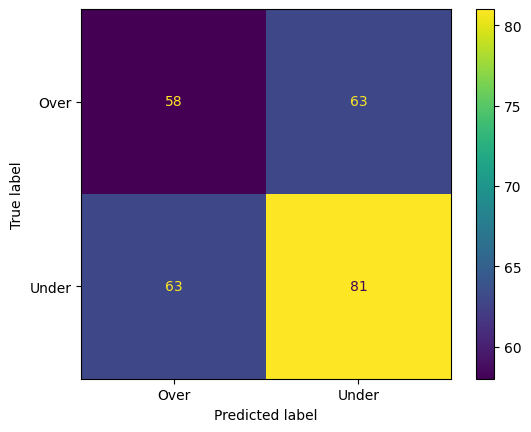

In [12]:
 # Set features and target
features = ['Spread', 'Total']
target = 'Under'

# Iterate over last 4 seasons ###############################################################################
for season in [2021, 2022, 2023]:
    # Display current season
    print(f"Processing season: {season}")
    
    # Initialise the season aggregates
    y_preds = []
    y_trues = []
    
    # Iterate over each week
    for week in range(1, 19):
        # Display current week
        print(f' Week {week:>2}:', end=' ')
        
        # Create training set
        train_df = nfl_df.query('Season < @season or (Season == @season and Week < @week) and True_Total != Total')
        
        # Create test set
        test_df = nfl_df.query('Season == @season and Week == @week and True_Total != Total')
        
        # Create X_train, y_train, X_test, y_test
        X_train = train_df[features]
        y_train = train_df[target]
        X_test = test_df[features]
        y_test = test_df[target]
        
        # Create model
        model = KNeighborsClassifier(n_neighbors=7)
        
        # Train model
        clf = model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = clf.predict(X_test)
        
        # Get true values
        y_true = y_test
        
        # Display accuracy
        print(f"Accuracy: {accuracy_score(y_true, y_pred):.2%}")
        
        # Append predictions and true values
        y_preds.extend(y_pred)
        y_trues.extend(y_true)
        
    # Display the total accuracy score for the current season
    print(f'Season {season}: Total accuracy score={accuracy_score(y_trues, y_preds):.2%}')
    
    # Display the classification report for the current season
    print(f'\nClassification Report for {season}:')
    print(classification_report(y_trues, y_preds, target_names=['Over','Under']))
    
    # Display the confusion matrix for the current season
    cm = confusion_matrix(y_trues, y_preds)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Over','Under'])
    cm_display.plot()
    plt.grid(False)
    plt.show()
